## Installation

In [ ]:
# pip install pyarrow
# pip install --upgrade numpy
# pip install h5py

In [35]:
# pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 25.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 21.8 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.4.0-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


## Code

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
tqdm.pandas()
pd.options.display.max_colwidth = 10000

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading Train Data 

In [2]:
train_df = pd.read_csv(r'train.csv')

### Mapping train_eegs and train_spectogram  to  its Full path

In [3]:
def create_id_mapping(paths_list):
    id_map = {}
    for path in paths_list:
        file_id = os.path.basename(path).split('.')[0]  # Corrected to extract the file ID correctly
        id_map[file_id] = path
    return id_map

def mapping_id(ids, id_map):
    return id_map.get(ids)

In [4]:
# Create ID mappings for train_eeg_path_list and train_spectrograms_path_list
train_eeg_path_list = glob.glob("train_eegs/*")
train_spectrograms_path_list = glob.glob("train_spectrograms/*")
eeg_id_map = create_id_mapping(train_eeg_path_list)
spectrograms_id_map = create_id_mapping(train_spectrograms_path_list)

# Example usage:
print("Mapping train_eeg_path_list","-"*60)
train_df['eeg_path'] = train_df['eeg_id'].astype(str).progress_apply(lambda x: mapping_id(x, eeg_id_map))

print("Mapping train_spectrograms_path_list","-"*60)
train_df['spectrograms_path'] = train_df['spectrogram_id'].astype(str).progress_apply(lambda x: mapping_id(x, spectrograms_id_map))

Mapping train_eeg_path_list ------------------------------------------------------------


100%|██████████| 106800/106800 [00:00<00:00, 2324425.54it/s]


Mapping train_spectrograms_path_list ------------------------------------------------------------


100%|██████████| 106800/106800 [00:00<00:00, 2310398.78it/s]


In [5]:
train_df.head(1)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spectrograms_path
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,train_eegs/1628180742.parquet,train_spectrograms/353733.parquet


### Mapping test_eegs and test_spectogram  to  its Full path

In [6]:
test_df = pd.read_csv(r'test.csv')

In [7]:
# Create ID mappings for train_eeg_path_list and train_spectrograms_path_list
test_eeg_path_list = glob.glob("test_eegs/*")
test_spectrograms_path_list = glob.glob("test_spectrograms/*")
eeg_id_map = create_id_mapping(test_eeg_path_list)
spectrograms_id_map = create_id_mapping(test_spectrograms_path_list)

# Example usage:
print("Mapping train_eeg_path_list","-"*60)
test_df['eeg_path'] = test_df['eeg_id'].astype(str).progress_apply(lambda x: mapping_id(x, eeg_id_map))

print("Mapping train_spectrograms_path_list","-"*60)
test_df['spectrograms_path'] = test_df['spectrogram_id'].astype(str).progress_apply(lambda x: mapping_id(x, spectrograms_id_map))

Mapping train_eeg_path_list ------------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 3515.76it/s]


Mapping train_spectrograms_path_list ------------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 4554.08it/s]


In [8]:
test_df.head(1)

,spectrogram_id,eeg_id,patient_id,eeg_path,spectrograms_path
0,853520,3911565283,6885,test_eegs/3911565283.parquet,test_spectrograms/853520.parquet


#### Now We Will Create A Function Which Will Convert The parquet file to .npy format i.e numpy format

In [9]:
def parquet_to_numpy(parquet_path):
    # Read the Parquet file into a DataFrame
    spec_df = pd.read_parquet(parquet_path)
    
    # Process the DataFrame to convert it into a numpy array
    spec_array = spec_df.fillna(0).values[:, 1:].T  # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec_array = spec_array.astype("float32")
    
    return spec_array

### Preprocesing The Image To Get The Better Visualization of the Image
[Taking Help To Preprocess The Image From This Notebook](https://www.kaggle.com/code/awsaf49/hms-hbac-kerascv-starter-notebook//)

In [10]:
def preprocess_spectrogram(image_array):

    # Normalization: Ensures that the pixel values are within a certain range
    # This helps in stabilizing the training process and ensures faster convergence
    image_array = image_array.astype('float32')
    image_array -= np.min(image_array)
    image_array /= np.max(image_array) + 1e-4
    
    # Log Transformation: Enhances contrast and reduces the effect of outliers
    # It helps in better visualization of the spectrogram features
    image_array = np.log(image_array + 1e-4)
    
    # Mean Subtraction: Centers the data around zero
    # This helps in reducing bias and improving the stability of the model
    mean = np.mean(image_array)
    image_array -= mean
    
    # Standardization: Scales the data to have zero mean and unit variance
    # It ensures that all features are on a similar scale, which can improve model performance
    std = np.std(image_array)
    image_array /= std + 1e-6
    
    return image_array

## Creating Train And Test Data Directory

In [11]:
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, "train")
test_dir  = os.path.join(current_dir, "test")
print("train_dir--->", train_dir)
print("test_dir---->", test_dir)
os.makedirs(train_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)

train_dir---> /home/ash/projects/hw/hms-harmful-brain-activity-classification/train
test_dir----> /home/ash/projects/hw/hms-harmful-brain-activity-classification/test


### Dumping Train Spectograms Data To Train Dir

In [12]:
# from PIL import Image

# for i in tqdm(train_df['spectrograms_path'].unique()):
#     img_array = preprocess_spectrogram(parquet_to_numpy(i))

#     img_name = os.path.basename(i).split('.')[0] + ".jpeg"
#     spectrograms_path = os.path.join(train_dir, "spectrograms")
#     os.makedirs(spectrograms_path, exist_ok=True)
    
#     plt.imsave(os.path.join(spectrograms_path, img_name), img_array)

### Dumping Test Spectograms to the Test Dir

In [13]:
# from PIL import Image

# for i in tqdm(test_df['spectrograms_path'].unique()):
#     img_array = preprocess_spectrogram(parquet_to_numpy(i))

#     img_name = os.path.basename(i).split('.')[0] + ".jpeg"
#     spectrograms_path = os.path.join(test_dir, "spectrograms")
#     os.makedirs(spectrograms_path, exist_ok=True)
    
#     plt.imsave(os.path.join(spectrograms_path, img_name), img_array)

## Renaming Train Image In Train Directory Adding Class To The Train Image

In [14]:
xx = train_df['spectrograms_path expert_consensus'.split()].drop_duplicates().reset_index(drop = True)
dict_xx = dict(zip(xx['spectrograms_path'], xx['expert_consensus']))

In [15]:
for original_path in tqdm(glob.glob("train/spectrograms/*")):
    # Extract the image ID from the file name
    img_id = os.path.basename(original_path).split('.')[-2]
    # Find the corresponding value in dict_xx based on the image ID
    xx = [v for k, v in dict_xx.items() if img_id in k][0]
    
    # Construct the new file name with the same directory path
    directory_path = os.path.dirname(original_path)
    new_filename = f"{xx}.{img_id}.jpeg"
    
    # Construct the new file path
    new_path = os.path.join(directory_path, new_filename)
    
    # Rename the file
    os.rename(original_path, new_path)

100%|██████████| 11138/11138 [00:04<00:00, 2559.51it/s]


In [16]:
del xx, dict_xx

### Creating A Function Which Will Plot The Random Image From The Directory

In [17]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def plot_random_images(dir_path, num_images, folder_name):
    if not os.path.exists(dir_path):
        print("Directory does not exist.")
        return
    
    image_files = [f for f in os.listdir(dir_path) if f.endswith('.jpeg') or f.endswith('.png') or f.endswith('.jpg')]
    if len(image_files) == 0:
        print("No image files found in the directory.")
        return
    
    # Shuffle the list of image files
    random.shuffle(image_files)
    
    # Limit the number of images to plot
    num_images = min(num_images, len(image_files))
    
    # Calculate the number of rows and columns based on the aspect ratio of the images
    num_rows = int(num_images ** 0.5)
    num_cols = (num_images + num_rows - 1) // num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i in range(num_images):
        img_path = os.path.join(dir_path, image_files[i])
        img = Image.open(img_path)

        row = i // num_cols
        col = i % num_cols

        ax = axes[row, col]
        ax.imshow(img, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(image_files[i], fontsize=8, wrap=True)

    # Hide any remaining empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    plt.suptitle(folder_name, fontsize=16)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust spacing between subplots
    plt.show()

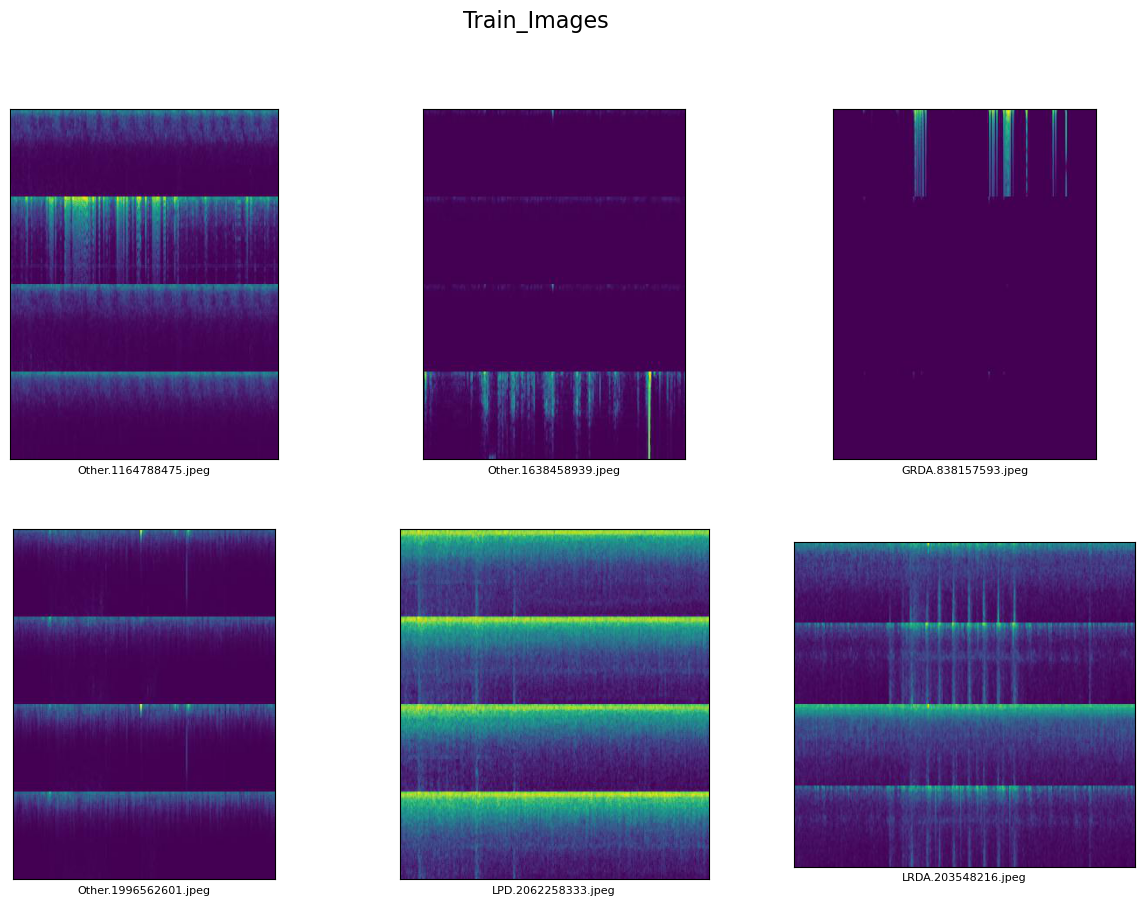

In [18]:
training_dir_spectrograms = 'train/spectrograms'
plot_random_images(training_dir_spectrograms, 6, "Train_Images")

 ### Dumping of the data is completed

#### Now We Will Create A Train Data Frame Which Will Contain  Training Image Path And Their Class Along With Their EEG_ID

#### This will Be Our Final Train Data Frame

In [19]:
def create_id_mapping(paths_list):
    id_map = {}
    for path in paths_list:
        file_id = os.path.basename(path).split('.')[1]  # Corrected to extract the file ID correctly
        id_map[file_id] = path
    return id_map

def mapping_id(ids, id_map):
    return id_map.get(ids)

In [20]:
# Create ID mappings for train_eeg_path_list and train_spectrograms_path_list
train_spectrograms_path_list = glob.glob("train/spectrograms/*")
spectrograms_id_map = create_id_mapping(train_spectrograms_path_list)

train_df = train_df['eeg_id spectrogram_id expert_consensus'.split()].drop_duplicates().reset_index(drop = True)

train_df['spectrograms_path'] = train_df['spectrogram_id'].astype(str).progress_apply(lambda x: mapping_id(x, spectrograms_id_map))

100%|██████████| 18013/18013 [00:00<00:00, 2212875.58it/s]


In [21]:
train_df['spectrograms_path']

0         train/spectrograms/Seizure.353733.jpeg
1             train/spectrograms/GPD.924234.jpeg
2            train/spectrograms/LRDA.999431.jpeg
3           train/spectrograms/LRDA.1084844.jpeg
4        train/spectrograms/Seizure.1219001.jpeg
                          ...                   
18008     train/spectrograms/LPD.2146798838.jpeg
18009     train/spectrograms/LPD.2146798838.jpeg
18010     train/spectrograms/LPD.2146798838.jpeg
18011     train/spectrograms/LPD.2147312808.jpeg
18012    train/spectrograms/LRDA.2147388374.jpeg
Name: spectrograms_path, Length: 18013, dtype: object

### Creating Train And Validation Split

In [22]:
train_df.head(2)

,eeg_id,spectrogram_id,expert_consensus,spectrograms_path
0,1628180742,353733,Seizure,train/spectrograms/Seizure.353733.jpeg
1,2277392603,924234,GPD,train/spectrograms/GPD.924234.jpeg


In [23]:
from sklearn.model_selection import train_test_split
train_dataset, valid_dataset = train_test_split(train_df ,test_size = 0.3 , random_state = 42, shuffle = True,
                                               stratify = train_df['expert_consensus'])

### Training Set Validation Set

In [24]:
train_dataset.head(1)

,eeg_id,spectrogram_id,expert_consensus,spectrograms_path
1859,2316276690,226714583,Other,train/spectrograms/Seizure.226714583.jpeg


### Image Data Generator

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

2024-04-15 23:16:52.232213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 23:16:52.232241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 23:16:52.233353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 23:16:52.238450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 23:16:52.773571: W tensorflow/compiler/tf2

### Training Set Validation Set

In [26]:
training_set = train_datagen.flow_from_dataframe(
                        dataframe = train_dataset,
                        x_col = 'spectrograms_path',
                        y_col = 'expert_consensus',
                        target_size=(299,299),
                        color_mode='rgb',
                        class_mode = 'categorical',
                        batch_size= 64)

validation_set = test_datagen.flow_from_dataframe(
                dataframe = valid_dataset,
                x_col = 'spectrograms_path',
                y_col = 'expert_consensus',
                color_mode='rgb',
                target_size = (299, 299),
                class_mode = 'categorical',
                batch_size = 64)

Found 12609 validated image filenames belonging to 6 classes.
Found 5404 validated image filenames belonging to 6 classes.


### Importing Multiple Transffer Learning Technique 

In [27]:
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2, InceptionResNetV2

def create_combined_model(input_shape=(299, 299, 3)):
    # Input layer
    input_tensor = Input(shape=input_shape)

    # Initialize lists to store outputs of each model
    outputs = []

    # Loop through each base model and perform transfer learning
    for base_model in [ResNet50V2, InceptionResNetV2]:
        # Load pre-trained model without top layers
        base_model = base_model(weights='imagenet', include_top=False, input_tensor=input_tensor)
        # Freeze layers
        for layer in base_model.layers[:90]:
            layer.trainable = False
        # Get output of the base model
        output = base_model.output
        # Flatten the output
        output = Flatten()(output)
        # Append to outputs list
        outputs.append(output)

    # Concatenate outputs vertically
    concatenated_output = Concatenate(axis=1)(outputs)

    # Apply dropout
    output = Dropout(0.8)(concatenated_output)

    # Output layer
    output = Dense(6, activation='softmax')(output)

    # Combine models
    combine_model = Model(inputs=[input_tensor], outputs=output)

    return combine_model

In [28]:
# Create and compile the model
combine_model = create_combined_model()
combine_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                      metrics=['accuracy'])
print("Total number of layers in the model:---> ", len(combine_model.layers))

2024-04-15 23:17:04.621451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 23:17:04.621790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 23:17:04.658920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Total number of layers in the model:--->  974


### Defining CallBack Function

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#learning_rate reduce module
lr_reduce = ReduceLROnPlateau('val_loss', patience=3, 
                                              factor=0.5, min_lr=1e-6)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=4,
                              verbose=0, restore_best_weights=True)

### Fitting The Model

In [30]:
history = combine_model.fit(training_set,
                         batch_size = 512,
                         epochs=30,
                         validation_data=validation_set,
                         callbacks = [lr_reduce, early_stopper],
                         verbose=1, shuffle=True)

Epoch 1/30


2024-04-15 23:17:50.419899: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-15 23:17:55.080378: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d81b7312780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 23:17:55.080397: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-15 23:17:55.080402: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-15 23:17:55.085828: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713237475.160208   70423 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 [==============================] - 146s 456ms/step - loss: 4.6848 - accuracy: 0.4039 - val_loss: 2631.5935 - val_accuracy: 0.2607 - lr: 0.0010
Epoch 2/30
198/198 [==============================] - 82s 412ms/step - loss: 4.9222 - accuracy: 0.4276 - val_loss: 495.2961 - val_accuracy: 0.1101 - lr: 0.0010
Epoch 3/30
198/198 [==============================] - 82s 414ms/step - loss: 5.6793 - accuracy: 0.4464 - val_loss: 62.8742 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 4/30
198/198 [==============================] - 82s 414ms/step - loss: 5.2264 - accuracy: 0.4467 - val_loss: 32.2186 - val_accuracy: 0.4180 - lr: 0.0010
Epoch 5/30
198/198 [==============================] - 82s 416ms/step - loss: 4.4973 - accuracy: 0.4484 - val_loss: 13.8888 - val_accuracy: 0.3109 - lr: 0.0010
Epoch 6/30
198/198 [==============================] - 82s 412ms/step - loss: 5.4510 - accuracy: 0.4462 - val_loss: 148.2281 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 7/30
198/198 [==============================] 

## Plot Accuracy Loss

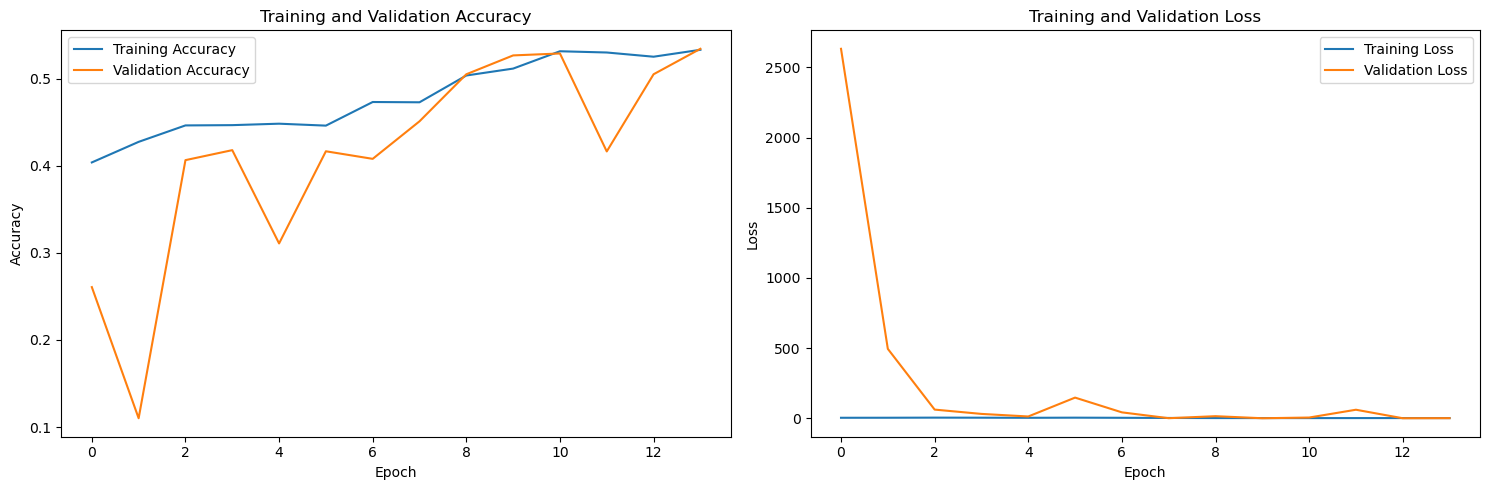

In [31]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracy values
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot training and validation loss values
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### Create A Model Prediction Function 

In [33]:
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [34]:
print("Class Indeces Are :-->", validation_set.class_indices)

Class Indeces Are :--> {'GPD': 0, 'GRDA': 1, 'LPD': 2, 'LRDA': 3, 'Other': 4, 'Seizure': 5}


In [35]:
valid_dataset.head(1)

,eeg_id,spectrogram_id,expert_consensus,spectrograms_path
8627,3843295938,1023320297,Other,train/spectrograms/GPD.1023320297.jpeg


In [36]:
### Model Prediction Function

def model_prediction(img_path, model, target_size=(299, 299)):
    # Load and preprocess the image
    img = Image.open(img_path)
    img_resized = img.resize(target_size)  # Resize the image to the input size of the model
    
    # Expand the dimensions of the image array to match the input shape expected by the model
    img_expanded = np.expand_dims(img_resized, axis=0)
    
    # Make prediction using the model
    predictions = model.predict(img_expanded, verbose=False)
    predicted_class_index = np.argmax(predictions)
    
    # Map the predicted class index to its corresponding label
    predicted_label = next((class_label for class_label, index in validation_set.class_indices.items() if index == predicted_class_index), None)
    
    return predicted_label

In [38]:
image_path = 'train/spectrograms/GPD.1023320297.jpeg'
model_prediction(image_path , combine_model)

'LPD'

### Top 10 Prediction On The Validation Data

In [39]:
valid_test =  valid_dataset['spectrograms_path expert_consensus'.split()].drop_duplicates().reset_index(drop = True).sample(10)
valid_test['ModelPrediction'] = valid_test['spectrograms_path'].progress_apply(lambda x: model_prediction(x, combine_model))

100%|██████████| 10/10 [00:00<00:00, 15.80it/s]


### Plotting Actual/Model Prediction 

In [40]:
def plot_predict(img_path, model):
    # Load the image
    img_array = cv2.imread(img_path)

    # Display the image
    plt.imshow(img_array)
    
    # Make prediction using the model
    prediction = model_prediction(img_path, model)
    
    # Set the title and x label
    plt.title("Prediction: " + prediction, color='red')
    plt.xlabel("Actual Image: " + img_path.split('/')[-1].split('.')[0])

    plt.show()

In [41]:
valid_dataset.head(1)

,eeg_id,spectrogram_id,expert_consensus,spectrograms_path
8627,3843295938,1023320297,Other,train/spectrograms/GPD.1023320297.jpeg


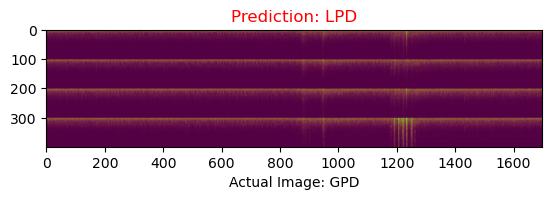

In [43]:
img_path  = 'train/spectrograms/GPD.1023320297.jpeg'
plot_predict(img_path, model= combine_model)

### Now We Will Do The Prediction On The Test Data 

In [44]:
test_dir = 'test'
test_prediction = pd.DataFrame(glob.glob(test_dir+'/spectrograms/*'),columns = ['img_path'])
test_prediction['ModelPrediction'] = test_prediction['img_path'].progress_apply(lambda x: model_prediction(x, model= combine_model))


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


In [45]:
test_prediction

,img_path,ModelPrediction
0,test/spectrograms/853520.jpeg,Other


### 📩 | Submission¶


In [46]:
def model_probability(img_path, model, target_size=(299, 299)):
    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize the image to the input size of the model
    
    # Expand the dimensions of the image array to match the input shape expected by the model
    expand_dim = np.expand_dims(img, axis=0)
    
    # Make prediction using the model
    predictions = model.predict(expand_dim, verbose=False)[0]
    
    # Get class labels and indices
    class_indices = {v: k for k, v in validation_set.class_indices.items()}
    
    # Create dictionary with class labels as keys and model probabilities as values
    probabilities = {class_indices[i]: prob for i, prob in enumerate(predictions)}
    
    return probabilities

In [47]:
img_path = 'test/spectrograms/853520.jpeg'
model_prob = model_probability(img_path, model= combine_model, target_size=(299, 299))
model_prob

{'GPD': 0.015431288,
 'GRDA': 0.16926485,
 'LPD': 0.15181282,
 'LRDA': 0.09967921,
 'Other': 0.47448924,
 'Seizure': 0.08932263}

In [48]:
# Create a DataFrame from the model probabilities
submission_df = pd.DataFrame([model_prob], columns=model_prob.keys())

# Add 'eeg_id' column from test_df as the first column
submission_df.insert(0, 'eeg_id', test_df['eeg_id'].copy())

# Rename the columns
submission_df.rename(columns={
    'Seizure': 'seizure_vote',
    'LPD': 'lpd_vote',
    'GPD': 'gpd_vote',
    'LRDA': 'lrda_vote',
    'GRDA': 'grda_vote',
    'Other': 'other_vote'
}, inplace=True)

In [49]:
submission_df

,eeg_id,gpd_vote,grda_vote,lpd_vote,lrda_vote,other_vote,seizure_vote
0,3911565283,0.015431,0.169265,0.151813,0.099679,0.474489,0.089323


### Submitting Result

In [ ]:
# submission_df.to_csv("submission.csv", index=False)
# submission_df.head()


In [ ]:
# 